In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [3]:
users = pd.read_csv('cleaned_users.csv')
books = pd.read_csv('cleaned_books.csv')
ratings = pd.read_csv('Filtered_HighQuality_Ratings.csv')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings, books, on='ISBN', how='inner')

# First merge: Ratings with Books on 'ISBN'
ratings_books_merged = pd.merge(ratings, books, on='ISBN', how='inner')
# Second merge: Resulting DataFrame with Users on 'User-ID'
final_merged_df = pd.merge(ratings_books_merged, users, on='User-ID', how='inner')
# Save the merged DataFrame to a new CSV file
final_merged_df.to_csv('final_merge.csv', index=False)


In [4]:
#data = pd.read_csv('final_merge.csv')
df = pd.read_csv('final_merge.csv')
data = df.dropna()
data.reset_index(drop=True, inplace=True)

# Select relevant features
features = data[['User-ID', 'Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']]

# Aggregate data to create user profiles
user_profiles = features.groupby('User-ID').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],  # Most frequent author
    'Book-Publisher-Encode': lambda x: x.mode()[0],  # Most frequent publisher
    'Book-Rating': 'mean'  # Average rating
}).reset_index()

In [5]:
data


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Bin,Book-Author-Encode,Book-Publisher-Encode,Year-Of-Publication-Bin-Encode,User-City,User-State,User-Country,User-Age,User-Age-Bin,User-City_Encoded,User-State_Encoded,User-Country_Encoded
0,277427,002542730X,10,politically correct bedtime story modern tale ...,James Finn Garner,1994,John Wiley & Sons Inc,"[1980, 2000)",2660,622,4,gilbert,others,usa,48,40~60,3064,23,6
1,277427,0060006641,10,writing well th anniversary classic guide writ...,William Zinsser,2001,HarperResource,"[2000, 2020)",6400,525,5,gilbert,others,usa,48,40~60,3064,23,6
2,277427,0060542128,7,storm break,Heather Lowell,2003,HarperTorch,"[2000, 2020)",2330,528,5,gilbert,others,usa,48,40~60,3064,23,6
3,277427,0061009059,9,one money stephanie plum novel paperback,Janet Evanovich,1995,HarperTorch,"[1980, 2000)",2766,528,4,gilbert,others,usa,48,40~60,3064,23,6
4,277427,0152050167,10,whale rider,Witi Ihimaera,2003,Harcourt Paperbacks,"[2000, 2020)",6405,495,5,gilbert,others,usa,48,40~60,3064,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54586,35433,3499123665,10,die hexen von eastwick roman,John Updike,1987,Rowohlt Tb.,"[1980, 2000)",3145,1018,4,wangen,others,others,40,20~40,8858,23,3
54587,35433,3499150425,10,garp und wie er die welt sah,John Irving,1982,Rowohlt Tb.,"[1980, 2000)",3083,1018,4,wangen,others,others,40,20~40,8858,23,3
54588,35433,3548253881,9,da spiel,Stephen King,2002,Ullstein Tb,"[2000, 2020)",5762,1223,5,wangen,others,others,40,20~40,8858,23,3
54589,35433,3596259924,7,die unertragliche leichtigkeit de seins unbear...,Milan Kundera,1997,Distribooks Inc,"[1980, 2000)",4476,314,4,wangen,others,others,40,20~40,8858,23,3


In [6]:
# Initialize a scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(user_profiles[['Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating']])


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

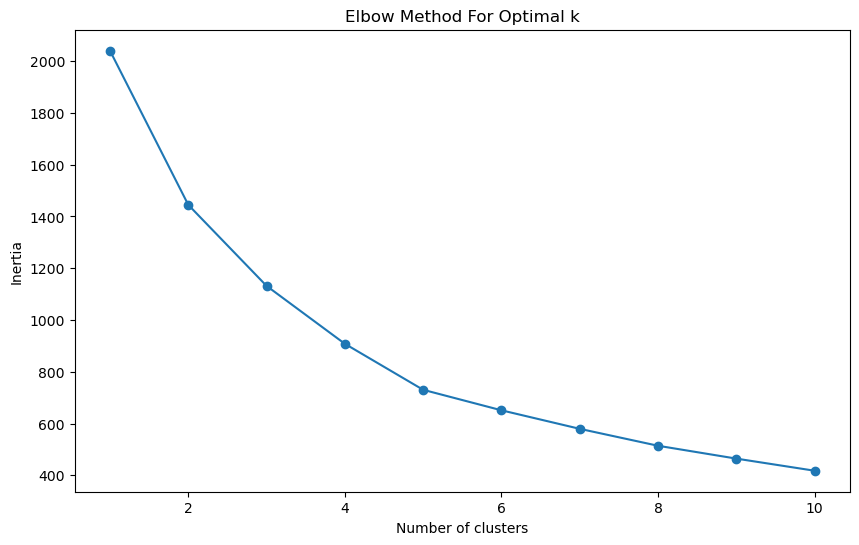

In [7]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [8]:
# Assuming the elbow is at k=3
kmeans = KMeans(n_clusters=3, random_state=1)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters back to the original data
user_profiles['Cluster'] = clusters

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


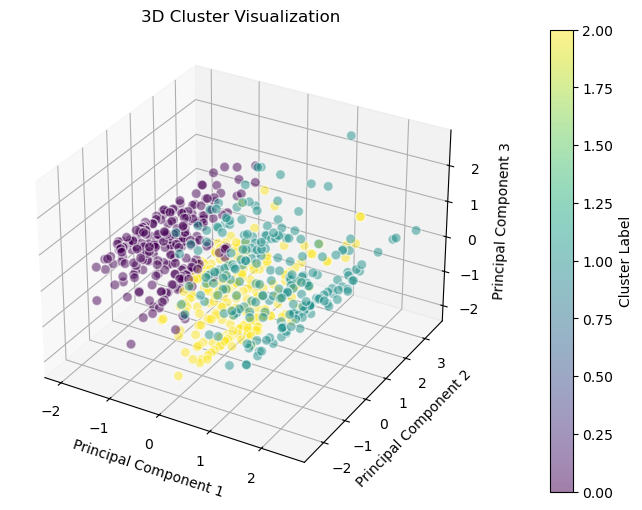

         Book-Author-Encode  Book-Publisher-Encode  Book-Rating
Cluster                                                        
0                       364                    111     8.082601
1                      5762                    913     7.877869
2                      5762                    111     7.702715


In [9]:
# Visualize clusters in 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], 
                     principal_components[:, 1], 
                     principal_components[:, 2], 
                     c=clusters, s=50, cmap='viridis', alpha=0.5, edgecolors='w')

# Labeling axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a color bar to understand which color represents which cluster
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Cluster Label')

# Setting title
ax.set_title('3D Cluster Visualization')

# Show plot
plt.show()

# Cluster Profiles
cluster_profiles = user_profiles.groupby('Cluster').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],
    'Book-Publisher-Encode': lambda x: x.mode()[0],
    'Book-Rating': 'mean'
})
print(cluster_profiles)

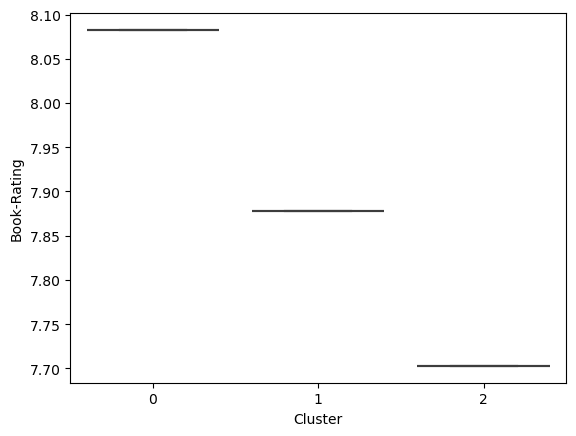

In [10]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Rating', data=cluster_profiles)
plt.show()

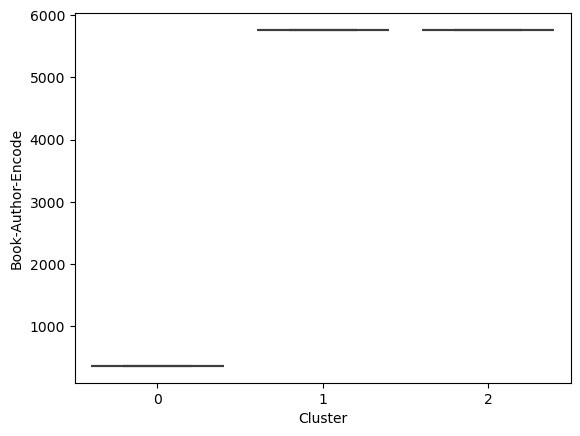

In [11]:
sns.boxplot(x='Cluster', y='Book-Author-Encode', data=cluster_profiles)
plt.show()

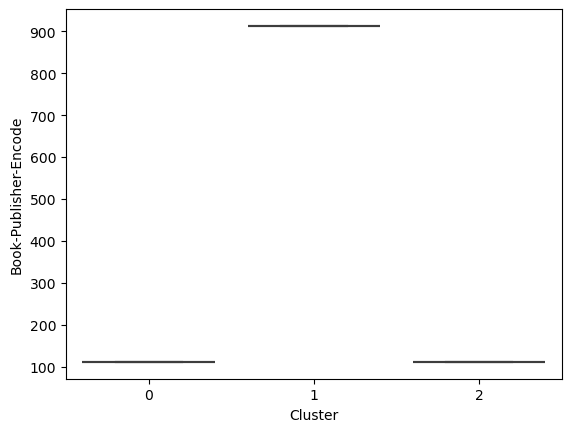

In [12]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Publisher-Encode', data=cluster_profiles)
plt.show()

In [12]:
def VAT(R):
    # Compute the pairwise distance matrix
    dist_matrix = squareform(pdist(R))

    # Initial ordering of indices
    J = list(range(0, len(R)))

    # Create the VAT reordered dissimilarity matrix
    i = np.argmin(dist_matrix)
    I = [i]
    J.remove(i)

    while J:
        i = J[np.argmin(dist_matrix[I][:, J], axis=1).argmax()]
        I.append(i)
        J.remove(i)

    RV = dist_matrix[:, I][I]
    return RV, R, I


In [13]:
# Assuming 'data' is your pandas DataFrame
# First, exclude any non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])  # This selects only numeric columns

# Check what columns are included, just to confirm
print("Numeric columns included:", numeric_data.columns)


Numeric columns included: Index(['User-ID', 'Book-Rating', 'Year-Of-Publication', 'Book-Author-Encode',
       'Book-Publisher-Encode', 'Year-Of-Publication-Bin-Encode', 'User-Age'],
      dtype='object')


In [15]:
# Select only numeric columns for normalization
numeric_data = data.select_dtypes(include=[np.number])  # This selects only numeric columns
# Optionally, manually specify columns if some numeric columns should be excluded or if errors persist
# numeric_data = data[['Column1', 'Column2', 'Column3']]  # Replace these names with your numeric columns


# Assuming 'data' is your DataFrame or NumPy array
normalized_data = MinMaxScaler().fit_transform(numeric_data)
print(len(normalized_data))


54591


In [46]:
# Compute VAT matrix
RV, _, I = VAT(normalized_data)

# Plotting the VAT heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(RV, cmap='gray', xticklabels=False, yticklabels=False)
plt.title("VAT")
plt.show()

: 